<p><font size="6"><b> CASE - CurieuzeNeuzen citizen science air quality data</b></font></p>


> *DS Python for GIS and Geoscience*  
> *September, 2024*
>
> *© 2024, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

Air pollution remains a key environmental problem in an increasingly urbanized world. While concentrations of traffic-related pollutants like nitrogen dioxide (NO2) are known to vary over short distances, official monitoring networks remain inherently sparse, as reference stations are costly to construct and operate.

The [**CurieuzeNeuzen**](https://curieuzeneuzen.be/curieuzeneuzen-vlaanderen-2018/) citizen science project collected a large, spatially distributed dataset that can complement official monitoring. In a first edition in 2016, in Antwerp, 2000 citizens were involved. This success was followed by a second edition in 2018 engaging 20.000 citizens across Flanders, a highly urbanized, industrialized and densely populated region in Europe. The participants measured the NO2 concentrations in front of their house using a low-cost sampler design (see picture below, where passive sampling tubes are attached using a panel to a window at the facade). 

Source: preprint paper at https://eartharxiv.org/repository/view/19/

In this case study, we are going to make use of the data collected across Flanders in 2018: explore the data and investigate relationships with other variables.

<img src="../img/CN_measurement_setup.png" alt="Measurement panel" style="width:800px">

In [1]:
import numpy as np
import pandas as pd
import geopandas

import matplotlib.pyplot as plt

## Importing and exploring the data

<div class="alert alert-success">

**EXERCISE**:

* Read the csv file from `data/CN_Flanders_open_dataset.csv` into a DataFrame `df` and inspect the data.
* How many measurements do we have?

</div>

In [2]:
df = pd.read_csv("./data/CN_Flanders_open_dataset.csv")
df

code           campaign   no2       lat       lon
0        1387656             facade  23.0  50.82594  4.704003
1         192852             facade  47.3  51.21328  4.444702
2         192873             facade  21.2  51.30897  4.188672
3         192876             facade  26.6  51.09620  3.991424
4         192879             facade  25.6  51.19922  4.461859
...          ...                ...   ...       ...       ...
17881  STAT_R811  reference station  18.7  51.25159  4.491521
17882  STAT_R817  reference station  24.8  51.17741  4.417936
17883  STAT_R831  reference station  23.8  51.34881  4.339557
17884  STAT_R833  reference station  22.0  51.32855  4.363960
17885  STAT_SZ02  reference station  19.0  50.91298  4.512118

[17886 rows x 5 columns]

In [3]:
len(df)

17886

The dataset contains longitude/latitude columns of the measurement locations, the measured NO2 concentration, and in addition also a "campaign" column indicating the type of measurement location (and an internal "code", which we will ignore here).

<div class="alert alert-success">

**EXERCISE**:

* Check the unique values of the "campaign" columns and how many occurrences those have.

    
<details><summary>Hints</summary>

* A pandas Series has a `value_counts()` method that counts the unique values of the column.

</details>

</div>

In [4]:
df["campaign"].value_counts()

campaign
facade               17842
background              23
reference station       21
Name: count, dtype: int64

Most of the measurements are performed at the facade of the house or building of a participant. In addition, some measurement tubes were also placed next to reference monitoring stations of the VMM and in background locations (e.g. nature reserve or park).

Let's now explore the measured NO2 concentrations.

<div class="alert alert-success">

**EXERCISE**:

* Calculate the overall average NO2 concentration of all locations (i.e. the mean of the "no2" column). 
* Calculate a combination of descriptive statistics of the NO2 concentration using the `describe()` method.
* Make a histogram of the NO2 concentrations to get a visual idea of the distribution of the concentrations.
    
<details><summary>Hints</summary>

* To calculate the mean of a column, we first need to select it: using the square bracket notation `df[colname]`
* The average can be calculate with the `mean()` method
* A histogram of a column can be plotted with the `hist()` method

</details>

</div>

In [5]:
df["no2"].mean()

np.float64(22.782818964553282)

In [6]:
df["no2"].describe()

count    17886.000000
mean        22.782819
std          6.422454
min         10.900000
25%         18.300000
50%         21.100000
75%         25.500000
max         75.300000
Name: no2, dtype: float64

A histogram:

<Axes: ylabel='Frequency'>

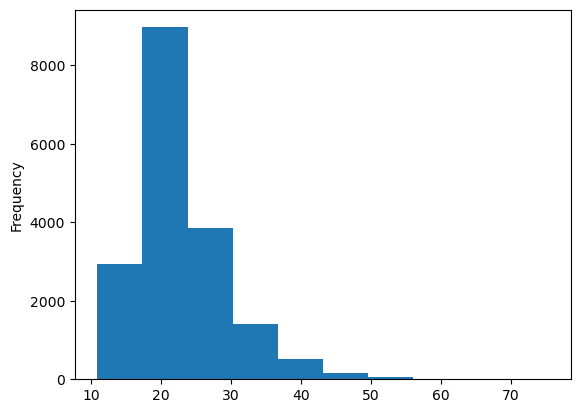

In [7]:
df['no2'].plot.hist()

A more expanded histogram (not asked in the exercise, but uncomment to check the code)

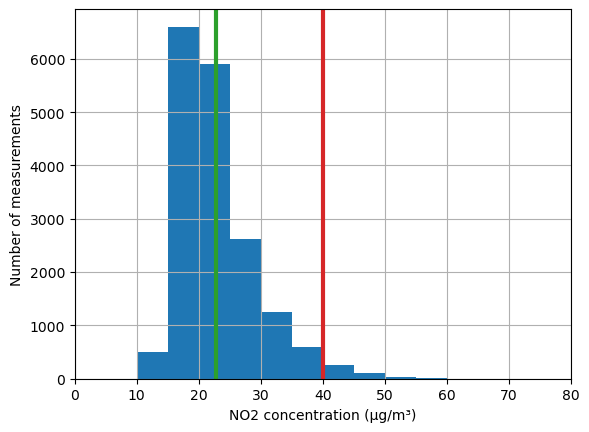

In [8]:
fig, ax = plt.subplots()
# using predefined bins
df['no2'].plot.hist(ax=ax, bins=np.arange(0, 80, 5))
# adding x/y axis labels, and setting the range for the x axis
ax.set(xlabel="NO2 concentration (µg/m³)",
       ylabel="Number of measurements", xlim=(0,80))
# adding a line with the mean
ax.axvline(x=df['no2'].mean(), color='C2', linewidth=3)
# adding a line with the EU yearly limit value of 40 µg/m³
ax.axvline(x=40, color='C3', linewidth=3)
ax.grid()

<div class="alert alert-success">

**EXERCISE**:

* Determine the percentage of locations that exceed the EU and WHO yearly limit value of 40 µg/m³.

__Tip__: first create a boolean mask determining whether the NO2 concentration is above 40 or not. Using this boolean mask, you can determine the percentage of values that follow the condition.
    
<details><summary>Hints</summary>

* To know the fraction of `True` values in a boolean Series, we can use the `sum()` method, which is equivalent as counting the True values (True=1, False=0, so the sum is a count of the True values) and dividing by the total number of values. 

</details>

</div>

In [9]:
exceedances = df['no2'] > 40

In [10]:
exceedances.mean() * 100  # the mean is equivalent here to counting the True values and dividing by the total number of elements

np.float64(2.264340825226434)

So overall in Flanders, around 2.3% of the measurement locations exceeded the limit value. This might not seem much, but assuming that the dataset is representative for the population of Flanders (and effort was done to ensure this), around 150,000 inhabitants live in a place where the annual NO2 concentration at the front door exceeds the EU legal threshold value.  
We will also later see that this exceedance has a large spatial variation.

<div class="alert alert-success">

**EXERCISE**:

* What is the average measured concentration at the background location? Calculate this by first selecting the appropriate subset of the dataframe.
* More generally, what is the average measured concentration grouped on the "Campaign" type? 

<details><summary>Hints</summary>

* To calculate a grouped statistic, use the `groupby()` method. Pass as argument the name of the column on which you want to group.
* After the `groupby()` operation, we can (similarly as for a normal DataFrame) select a column and call the aggregation column (`df.groupby("class")["variable"].method()`).

</details>

</div>

In [11]:
df[df['campaign'] == "background"]["no2"].mean()

np.float64(14.756521739130434)

In [12]:
df.groupby('campaign')["no2"].mean()

campaign
background           14.756522
facade               22.789710
reference station    25.719048
Name: no2, dtype: float64

The background locations (parks, nature reserves) clearly show a lower concentration than the average location. Note that the number of observations in each class are very skewed, so those averages are not necessarily representative!

## Converting to a geospatial dataset

The provided data was a CSV file, and we explored it above as a pandas DataFrame. To further explore the dataset using the spatial aspects (point data), we will first convert it to a geopandas GeoDataFrame.

<div class="alert alert-success">

**EXERCISE**:

* Convert `df` into a GeoDataFrame, using the 'lat'/'lon' columns to create a Point geometry column (tip: check the `geopandas.points_from_xy()` function). Also specify the correct Coordinate Reference System with the `crs` keyword. Call the result `gdf`.
* Do a quick check to see the result is correct: look at the first rows, and make a simple plot of the GeoDataFrame with `.plot()` (you should recognize the shape of Flanders, if not, something went wrong)

    
<details><summary>Hints</summary>

* A GeoDataFrame can be created from an existing pandas.DataFrame by using the `geopandas.GeoDataFrame(...)` constructor. This constructor needs a `geometry=` keyword specifying either the name of the column that holds the geometries or either the geometry values.
* GeoPandas provides a helper function to create Point geometry values from a array or column of x and y coordinates: `geopandas.points_from_xy(x_values, y_values)`.
* Remember! The order of coordinates is (x, y), and for geographical coordinates this means the (lon, lat) order.
* Remember! The Coordinate Reference System typically used for geographical lon/lat coordinates is "EPSG:4326" (WGS84).

</details>

</div>

In [13]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")

In [14]:
gdf

code           campaign   no2       lat       lon  \
0        1387656             facade  23.0  50.82594  4.704003   
1         192852             facade  47.3  51.21328  4.444702   
2         192873             facade  21.2  51.30897  4.188672   
3         192876             facade  26.6  51.09620  3.991424   
4         192879             facade  25.6  51.19922  4.461859   
...          ...                ...   ...       ...       ...   
17881  STAT_R811  reference station  18.7  51.25159  4.491521   
17882  STAT_R817  reference station  24.8  51.17741  4.417936   
17883  STAT_R831  reference station  23.8  51.34881  4.339557   
17884  STAT_R833  reference station  22.0  51.32855  4.363960   
17885  STAT_SZ02  reference station  19.0  50.91298  4.512118   

                       geometry  
0        POINT (4.704 50.82594)  
1       POINT (4.4447 51.21328)  
2      POINT (4.18867 51.30897)  
3       POINT (3.99142 51.0962)  
4      POINT (4.46186 51.19922)  
...                         ...  
17881  POINT (4.49152 51.25159)  
17882  POINT (4.41794 51.17741)  
17883  POINT (4.33956 51.34881)  
17884  POINT (4.36396 51.32855)  
17885  POINT (4.51212 50.91298)  

[17886 rows x 6 columns]

<Axes: >

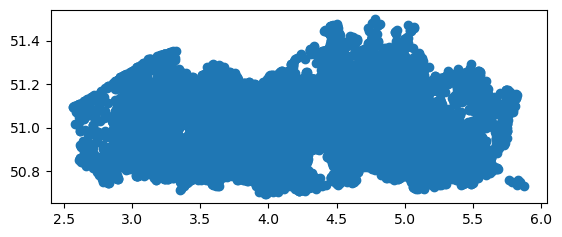

In [15]:
gdf.plot()

Let's make that last plot a bit more informative:

<div class="alert alert-success">

**EXERCISE**:

* Make a plot of the point locations of `gdf` and use the "no2" column to color the points.
* Make the figure a bit larger by specifying the `figsize=` keyword.

<details><summary>Hints</summary>

* The figure size can be specified with the `figsize=` keyword of the `plot()` method.
* For using one of the columns of the GeoDataFrame to determine the fill color, use the `column=` keyword.

</details>

</div>

<Axes: >

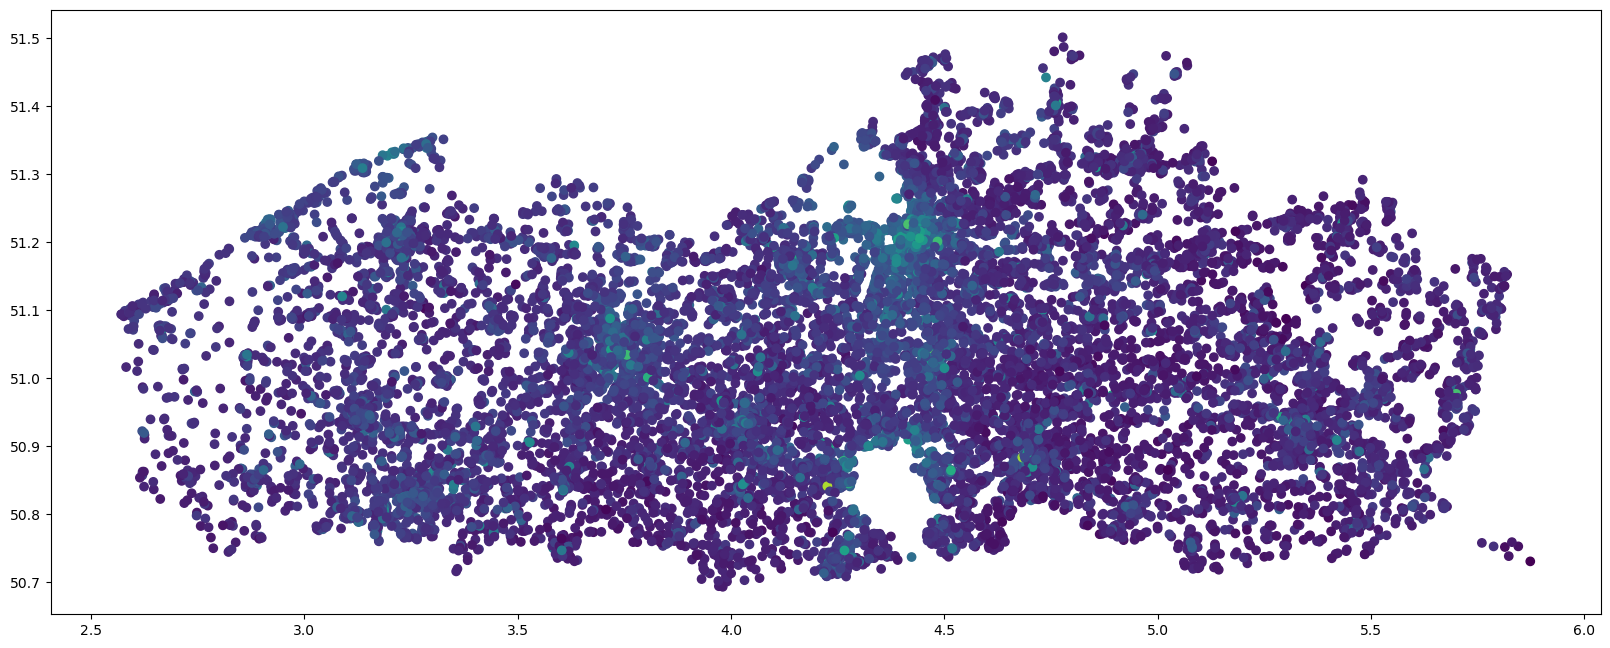

In [16]:
gdf.plot(column="no2", figsize=(20, 10))

We can already notice some spatial patterns: higher concentrations (and also more measurement locations) in urban areas. But, the visualization above is not really a good way to visualize many points. There are many alternatives (e.g. heatmaps, hexbins, etc), but in this case study we are going to make a [*choropleth* map](https://en.wikipedia.org/wiki/Choropleth_map): choropleths are maps onto which an attribute, a non-spatial variable, is displayed by coloring a certain area. 

As the unit of area, we will use the municipalities of Flanders.

## Combining with municipalities

We downloaded the publicly available municipality reference from geopunt.be ([Voorlopig referentiebestand gemeentegrenzen, toestand 16/05/2018](https://www.geopunt.be/catalogus/datasetfolder/9ff44cc4-5f16-4507-81a6-6810958b14df)), and added the Shapefile with the borders to the course repo: `data/VRBG/Refgem.shp`.

<div class="alert alert-success">

**EXERCISE**:

* Read the Shapefile with the municipalities into a variable called `muni`.
* Inspect the data and do a quick plot.
    
</div>

In [17]:
muni = geopandas.read_file("./data/VRBG/Refgem.shp")

In [18]:
muni.head()

OIDN   UIDN   VERSDATUM  TERRID   DATPUBLBS       NUMAC NISCODE  \
0  278.0  278.0  1900-01-01       1  1976-01-23  1975123003   13001   
1  209.0  209.0  1900-01-01       2  1982-12-29  1982001920   13031   
2   67.0   67.0  1900-01-01       3  1831-02-07        None   13025   
3   53.0   53.0  1900-01-01       4  1976-01-23  1975123003   72037   
4  102.0  102.0  1900-01-01       5  1982-12-29  1982001920   13036   

           NAAM        LENGTE       OPPERVL  \
0      Arendonk  32278.608018  5.501111e+07   
1  Oud-Turnhout  33317.260657  3.917257e+07   
2           Mol  77705.294504  1.144999e+08   
3  Hamont-Achel  31929.641885  4.373537e+07   
4         Retie  35339.133575  4.865207e+07   

                                            geometry  
0  POLYGON ((198892.29 231761.69, 202087.22 22819...  
1  POLYGON ((191910.672 228249.047, 192000.239 22...  
2  POLYGON ((203378.85 223128.86, 205356.45 22257...  
3  POLYGON ((230005.37 221212.32, 230240.58 22057...  
4  POLYGON ((200827.109 220823.391, 201389.922 22...

<Axes: >

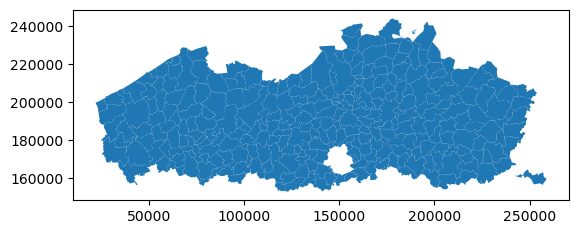

In [19]:
muni.plot()

Now we have a dataset with the municipalities, we want to know for each of the measurement locations in which municipality it is located. This is a "point-in-polygon" spatial join.

<div class="alert alert-success">

**EXERCISE**:

Before performing the spatial join, we need to ensure the two datasets are using the same Coordinate Reference System (CRS).

* Check the CRS of both `gdf` and `muni`. What kind of CRS are they using? Are they the same?
* Reproject the measurements to the Lambert 72 (EPSG:31370) reference system. Call the result `gdf_lambert`.

<details><summary>Hints</summary>

* The CRS of a GeoDataFrame can be checked by looking at the `crs` attribute.
* To reproject a GeoDataFrame to another CRS, we can use the `to_crs()` method.

</details>

</div>

In [20]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
muni.crs

<Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [22]:
gdf_lambert = gdf.to_crs("EPSG:31370")  # or .to_crs(muni.crs)
gdf_lambert.head()

code campaign   no2       lat       lon                       geometry
0  1387656   facade  23.0  50.82594  4.704003  POINT (173620.682 168443.754)
1   192852   facade  47.3  51.21328  4.444702   POINT (155306.731 211483.31)
2   192873   facade  21.2  51.30897  4.188672  POINT (137441.957 222141.788)
3   192876   facade  26.6  51.09620  3.991424  POINT (123567.247 198522.091)
4   192879   facade  25.6  51.19922  4.461859  POINT (156507.579 209920.455)

The EPSG:31370 or "Belgian Lambert 72" (https://epsg.io/31370) is the local, projected CRS most often used in Belgium.

<div class="alert alert-success">

**EXERCISE**:

* Add the municipality information to the measurements dataframe. We are mostly interested in the "NAAM" column of the municipalities dataframe (the name of the municipality). Call the result `gdf_combined`.
    
<details><summary>Hints</summary>

* Joining the measurement locations with the municipality information can be done with the `geopandas.sjoin()` function. The first argument is the dataframe to which we want to add information, the second argument the dataframe with the additional information.
* You can select a subset of columns when passing a GeoDataFrame to the `sjoin()` function.

</details>

</div>

In [23]:
gdf_combined = geopandas.sjoin(gdf_lambert, muni[["NAAM", "geometry"]])

In [24]:
gdf_combined.head()

code campaign   no2       lat       lon                       geometry  \
0  1387656   facade  23.0  50.82594  4.704003  POINT (173620.682 168443.754)   
1   192852   facade  47.3  51.21328  4.444702   POINT (155306.731 211483.31)   
2   192873   facade  21.2  51.30897  4.188672  POINT (137441.957 222141.788)   
3   192876   facade  26.6  51.09620  3.991424  POINT (123567.247 198522.091)   
4   192879   facade  25.6  51.19922  4.461859  POINT (156507.579 209920.455)   

   index_right          NAAM  
0          258  Oud-Heverlee  
1           65     Antwerpen  
2           70       Beveren  
3          125       Lokeren  
4           65     Antwerpen

<div class="alert alert-success">

**EXERCISE**:

* What is the average measured concentration in each municipality?
* Call the result `muni_mean`. Ensure we have a DataFrame with a NO2 columns and a column with the municipality name by calling the `reset_index()` method after the groupby operation.
* Merge those average concentrations with the municipalities GeoDataFrame (note: those have a common column "NAAM"). Call the merged dataframe `muni_no2`, and check the first rows.
    
<details><summary>Hints</summary>

* Something like `df.groupby("class")["variable"].mean()` returns a Series, with the group variable as the index. Calling `reset_index()` on the result then converts this into a DataFrame with 2 columns: the group variable and the calculated statistic.
* Merging two dataframe that have a common column can be done with the `pd.merge()` function. 

</details>

</div>

In [25]:
muni_mean = gdf_combined.groupby("NAAM")["no2"].mean()
muni_mean.head()

NAAM
Aalst         25.170196
Aalter        20.734951
Aarschot      19.738710
Aartselaar    28.256604
Affligem      24.745455
Name: no2, dtype: float64

In [26]:
muni_mean = muni_mean.reset_index()
muni_mean.head()

NAAM        no2
0       Aalst  25.170196
1      Aalter  20.734951
2    Aarschot  19.738710
3  Aartselaar  28.256604
4    Affligem  24.745455

In [27]:
muni_no2 = pd.merge(muni, muni_mean, on="NAAM")
muni_no2.head()

OIDN   UIDN   VERSDATUM  TERRID   DATPUBLBS       NUMAC NISCODE  \
0  278.0  278.0  1900-01-01       1  1976-01-23  1975123003   13001   
1  209.0  209.0  1900-01-01       2  1982-12-29  1982001920   13031   
2   67.0   67.0  1900-01-01       3  1831-02-07        None   13025   
3   53.0   53.0  1900-01-01       4  1976-01-23  1975123003   72037   
4  102.0  102.0  1900-01-01       5  1982-12-29  1982001920   13036   

           NAAM        LENGTE       OPPERVL  \
0      Arendonk  32278.608018  5.501111e+07   
1  Oud-Turnhout  33317.260657  3.917257e+07   
2           Mol  77705.294504  1.144999e+08   
3  Hamont-Achel  31929.641885  4.373537e+07   
4         Retie  35339.133575  4.865207e+07   

                                            geometry        no2  
0  POLYGON ((198892.29 231761.69, 202087.22 22819...  18.921053  
1  POLYGON ((191910.672 228249.047, 192000.239 22...  17.872973  
2  POLYGON ((203378.85 223128.86, 205356.45 22257...  19.103061  
3  POLYGON ((230005.37 221212.32, 230240.58 22057...  17.855172  
4  POLYGON ((200827.109 220823.391, 201389.922 22...  18.064286

<div class="alert alert-success">

**EXERCISE**:

* Make a choropleth of the municipalities using the average NO2 concentration as variable to color the municipality polygons.
* Set the figure size to be (16, 5), and add a legend.
    
<details><summary>Hints</summary>

* To specify which column to use to color the geometries in the plot, use the `column=` keyword of the `plot()` method.
* The figure size can be specified with the `figsize=` keyword of the `plot()` method.
* Pass `legend=True` to add a legend to the plot. The type of legend (continuous color bar, discrete legend) will be inferred from the plotted values.

</details>

</div>

<Axes: >

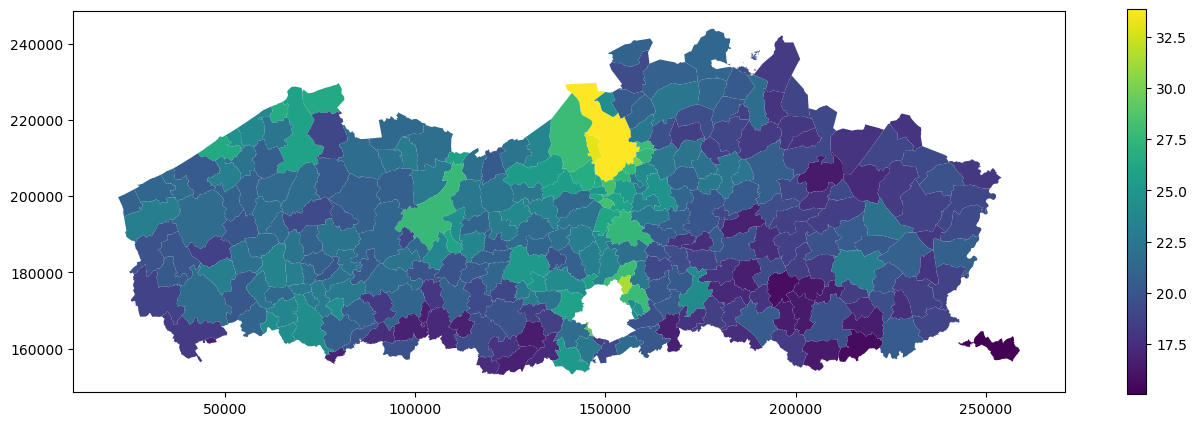

In [28]:
muni_no2.plot(column="no2", figsize=(16, 5), legend=True)

When specifying a numerical column to color the polygons, by default this results in a continuous color scale, as you can see above.

However, it is very difficult for the human eye to process small differences in color in a continuous scale. 
Therefore, to create effective choropleths, we typically classify the values into a set of discrete groups.

With GeoPandas' `plot()` method, you can control this with the `scheme` keyword (indicating which classification scheme to use, i.e how to divide the continuous range into a set of discrete classes) and the `k` keyword to indicate how many classes to use. This uses the [mapclassify](https://pysal.org/mapclassify/) package under the hood.

<div class="alert alert-success">

**EXERCISE**:

* Starting from the previous figure, specify a classification scheme and a number of classes to use. Check the help of the `plot()` method to see the different options, and experiment with those.
    
</div>

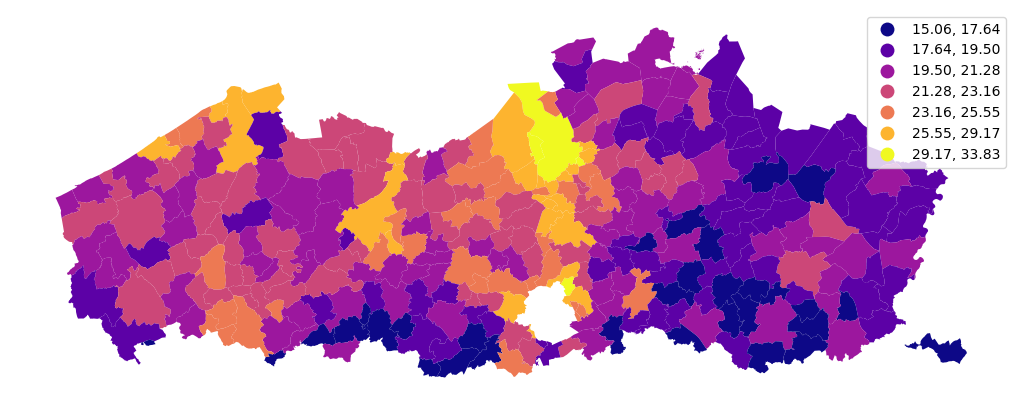

In [29]:
ax = muni_no2.plot(column="no2", figsize=(16, 5), legend=True, scheme="FisherJenks", k=7, cmap="plasma")
ax.set_axis_off()

<div class="alert alert-success">

**EXERCISE**:

* What is the percentage of exceedance for each municipality? Repeat the same calculation we did earlier on the original dataset `df`, but now using `gdf_combined` and grouped per municipality.
* Show the 10 municipalities with the highest percentage of exceedances.

<details><summary>Hints</summary>

* For showing the 10 highest values, we can either use the `sort_values()` sorting the highest values on top and showing the first 10 rows, or either use the `nlargest()` method as a short cut for this operation.
</details>

</div>

In [30]:
gdf_combined["exceedance"] = gdf_combined["no2"] > 40

In [31]:
exceedances_muni = gdf_combined.groupby("NAAM")["exceedance"].mean() * 100

In [32]:
exceedances_muni.sort_values(ascending=False).head(10)

NAAM
Antwerpen      17.114428
Vilvoorde       7.894737
Asse            6.493506
Melle           6.122449
Mechelen        6.008584
Berlare         5.882353
Zwijndrecht     5.714286
Dilbeek         5.600000
Gent            5.321782
Kaprijke        5.263158
Name: exceedance, dtype: float64

## Combining with Land Use data

The CORINE Land Cover (https://land.copernicus.eu/pan-european/corine-land-cover) is a program by the European Environment Agency (EEA) to provide an inventory of land cover in 44 classes of the European Union. The data is provided in both raster as vector format and with a resolution of 100m.

The data for the whole of Europe can be downloaded from the website (latest version: https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download). This is however a large dataset, so we downloaded the raster file and cropped it to cover Flanders, and this subset is included in the repo as `data/CLC2018_V2020_20u1_flanders.tif` (the code to do this cropping can be see at [data/preprocess_data.ipynb#CORINE-Land-Cover](data/preprocess_data.ipynb#CORINE-Land-Cover)).

The air quality is indirectly linked to land use, as the presence of pollution sources will depend on the land use. Therefore, in the following section we will determine the land use for each of the measurement locations based on the CORINE dataset and explore the relationship of the NO2 concentration and land use.

<div class="alert alert-success">

**EXERCISE**:

* Open the land cover raster file (`data/CLC2018_V2020_20u1_flanders.tif`) with xarray, inspect the metadata, and do a quick visualization.

<details><summary>Hints</summary>

* The tif file represents a single layer (with one band), so you can use `xarray.open_dataarray()` to read it into an xarray.DataArray.
* With `mask_and_scale=False` the `int8` data type will be kept when reading in the data.

</details>

</div>

In [33]:
import xarray

raster = xarray.open_dataarray("data/CLC2018_V2020_20u1_flanders.tif", engine="rasterio", mask_and_scale=False)
raster

<xarray.DataArray 'band_data' (band: 1, y: 1133, x: 2530)> Size: 3MB
[2866490 values with dtype=int8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 20kB 3.79e+06 3.79e+06 ... 4.042e+06 4.042e+06
  * y            (y) float64 9kB 3.178e+06 3.178e+06 ... 3.065e+06 3.065e+06
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -128
    scale_factor:   1.0
    add_offset:     0.0

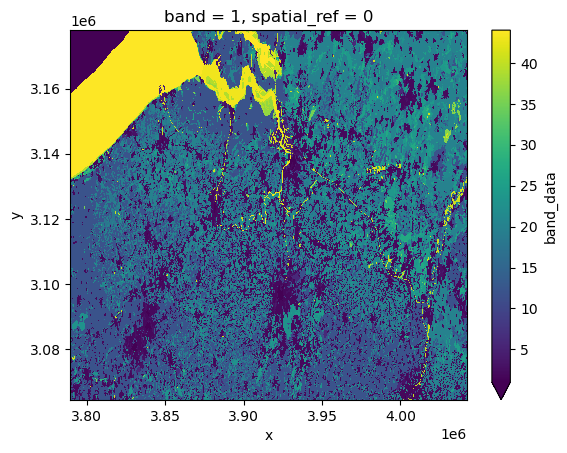

In [34]:
raster.plot(vmin=1, vmax=44)

The goal is now to query from the raster file the value of the land cover class for each of the measurement locations. This can be done with the `rasterstats` package and with the point locations of our GeoDataFrame. But first, we need to ensure that both our datasets are using the same CRS. In this case, it's easiest to reproject the point locations to the CRS of the raster file.

<div class="alert alert-success">

**EXERCISE**:

* What is the EPSG code of the Coordinate Reference System (CRS) of the raster file? You can find this in the metadata inspected with rasterio or xarray above.
* Reproject the point dataframe (`gdf`) to the CRS of the raster and assign this to a temporary variable `gdf_raster`.

<details><summary>Hints</summary>

* Reprojecting can be done with the `to_crs()` method of a GeoDataFrame, and the CRS can be specified in the form of "EPSG:xxxx".

</details>

</div>

In [35]:
raster.rio.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]')

In [36]:
gdf_raster = gdf.to_crs("EPSG:3035")
gdf_raster.head()

code campaign   no2       lat       lon                         geometry
0  1387656   facade  23.0  50.82594  4.704003   POINT (3948208.32 3092876.582)
1   192852   facade  47.3  51.21328  4.444702  POINT (3933249.515 3137216.482)
2   192873   facade  21.2  51.30897  4.188672    POINT (3916264.675 3149224.1)
3   192876   facade  26.6  51.09620  3.991424  POINT (3900625.411 3126731.909)
4   192879   facade  25.6  51.19922  4.461859  POINT (3934326.401 3135565.137)

<div class="alert alert-success">

**EXERCISE**:

* Use the `rasterstats.point_query()` function to determine the value of the raster for each of the points in the dataframe. Remember to use `gdf_raster` for passing the geometries.
* Because we have a raster file with discrete classes, ensure to pass `interpolate="nearest"` (the default "bilinear" will result in floats with decimals, not preserving the integers representing discrete classes).
* Assign the result to a new column "land_use" in `gdf`.
* Perform a `value_counts()` on this new column do get a quick idea of the new values obtained from the raster file.

Note that the query operation can take a while. Don't worry if it runs for around 20 seconds!
    
    
<details><summary>Hints</summary>

* Don't forget to first import the `rasterstats` package.
* The `point_query()` function takes as first argument the point geometries (this can be passed as a GeoSeries), and as second argument the path to the raster file (this will be opened by `rasterio` under the hood).

</details>

</div>

In [37]:
import rasterstats

In [38]:
gdf['land_use'] = rasterstats.point_query(gdf_raster.geometry, "data/CLC2018_V2020_20u1_flanders.tif", interpolate='nearest')

In [39]:
gdf['land_use'].value_counts()

land_use
2     14629
20      937
1       604
12      504
21      348
3       277
18      234
11       69
25       61
24       56
23       46
4        44
16       18
5        15
10       15
27        7
40        5
29        4
43        4
41        3
26        2
30        1
9         1
35        1
37        1
Name: count, dtype: int64

As you can see, we have obtained a large variety of land cover classes. To make this more practical to work with, we 

 1. want to convert the numbers into a class name, and 
 2. reduce the number of classes.

The full hierarchy (with 3 levels) of the 44 classes can be seen at https://wiki.openstreetmap.org/wiki/Corine_Land_Cover. For keeping the exercise a bit practical here, we prepared a simplified set of classes and provided a csv file with this information.  

This has a column "value" corresponding to the values used in the raster file, and a "group" column with the simplified classes that we will use for this exercise.

<div class="alert alert-success">

**EXERCISE**:

* Read the `"data/CLC2018_V2018_legend_grouped.csv"` as a dataframe and call it `legend`.

The additional steps, provided for you, use this information to convert the column of integer land use classes to a column with the simplified names. After that, we again use `value_counts()` on this new column, and we can see that we now have less classes.

<details><summary>Hints</summary>

* Reading a csv file can be done with the `pandas.read_csv()` function.

</details>

</div>

In [40]:
legend = pd.read_csv("data/CLC2018_V2018_legend_grouped.csv")
legend

code  value                                              class  \
0    111      1                            Continuous urban fabric   
1    112      2                         Discontinuous urban fabric   
2    121      3                     Industrial or commercial units   
3    122      4         Road and rail networks and associated land   
4    123      5                                         Port areas   
5    124      6                                           Airports   
6    131      7                           Mineral extraction sites   
7    132      8                                         Dump sites   
8    133      9                                 Construction sites   
9    141     10                                  Green urban areas   
10   142     11                       Sport and leisure facilities   
11   211     12                          Non-irrigated arable land   
12   212     13                         Permanently irrigated land   
13   213     14                                        Rice fields   
14   221     15                                          Vineyards   
15   222     16                  Fruit trees and berry plantations   
16   223     17                                       Olive groves   
17   231     18                                           Pastures   
18   241     19       Annual crops associated with permanent crops   
19   242     20                       Complex cultivation patterns   
20   243     21  Land principally occupied by agriculture with ...   
21   244     22                                Agro-forestry areas   
22   311     23                                Broad-leaved forest   
23   312     24                                  Coniferous forest   
24   313     25                                       Mixed forest   
25   321     26                                 Natural grasslands   
26   322     27                                Moors and heathland   
27   323     28                          Sclerophyllous vegetation   
28   324     29                        Transitional woodland-shrub   
29   331     30                                Beaches dunes sands   
30   332     31                                         Bare rocks   
31   333     32                           Sparsely vegetated areas   
32   334     33                                        Burnt areas   
33   335     34                        Glaciers and perpetual snow   
34   411     35                                     Inland marshes   
35   412     36                                          Peat bogs   
36   421     37                                       Salt marshes   
37   422     38                                            Salines   
38   423     39                                   Intertidal flats   
39   511     40                                      Water courses   
40   512     41                                       Water bodies   
41   521     42                                    Coastal lagoons   
42   522     43                                          Estuaries   
43   523     44                                      Sea and ocean   

                                group  
0             Continuous urban fabric  
1          Discontinuous urban fabric  
2      Industrial or commercial units  
3                     Transport units  
4                     Transport units  
5                     Transport units  
6   Mine, dump and construction sites  
7   Mine, dump and construction sites  
8   Mine, dump and construction sites  
9                   Green urban areas  
10                  Green urban areas  
11                Agricultural areas   
12                Agricultural areas   
13                Agricultural areas   
14                Agricultural areas   
15                Agricultural areas   
16                Agricultural areas   
17                Agricultural areas   
18                Agricultural areas   
19                Agricultural areas   
20           

Convert the "land_use" integer values to a column with land use class names:

In [41]:
value_to_group = dict(zip(legend['value'], legend['group']))

In [42]:
gdf['land_use_class'] = gdf['land_use'].replace(value_to_group)

In [43]:
gdf['land_use_class'].value_counts()

land_use_class
Discontinuous urban fabric           14629
Agricultural areas                    2041
Continuous urban fabric                604
Industrial or commercial units         277
Forest and seminatural areas           177
Green urban areas                       84
Transport units                         59
Water bodies                            12
Wetlands                                 2
Mine, dump and construction sites        1
Name: count, dtype: int64

Now we have the land use data, let's explore the air quality in relation to this land use.

We can see in the `value_counts()` result  above that we have a few classes with only very few observations, though (<50). Calculating statistics for those small groups is not very reliable, so lets leave them out for this exercises (note, this is not necessarily the best strategy in real life! Amongst others, we could also inspect those points and re-assign to a dominant land use class in the surrounding region).

<div class="alert alert-success">

**EXERCISE**:

* Assign the value counts of the "land_use_class" column to a variable `counts`. 
* Using "counts", we can determine which classes occur more then 50 times. 
* Using those frequent classes, filter the `gdf` to only include observations from those classes, and call this `subset`.
* Based on this subset, calculate the average NO2 concentration per land use class.


</div>

In [44]:
counts = gdf['land_use_class'].value_counts()

In [45]:
frequent_categories = counts.index[counts > 50]

In [46]:
subset = gdf[gdf["land_use_class"].isin(frequent_categories)]

In [47]:
subset.groupby("land_use_class")['no2'].mean()

land_use_class
Agricultural areas                19.145811
Continuous urban fabric           34.367715
Discontinuous urban fabric        22.779602
Forest and seminatural areas      17.427684
Green urban areas                 22.376190
Industrial or commercial units    25.736462
Transport units                   32.996610
Name: no2, dtype: float64

<div class="alert alert-success">

**EXERCISE**:

* Using the `seaborn` package and the `subset` DataFrame, make a boxplot of the NO2 concentration, splitted per land use class.

Don't forget to first import `seaborn`. We can use the `seaborn.boxplot()` function (check the help of this function to see which keywords to specify).
    
<details><summary>Hints</summary>

* With the `seaborn.boxplot()`, we can specify the `data=` keyword to pass the DataFrame from which to plot values, and the `x=` and `y=` keywords to specify which columns of the DataFrame to use.

</details>

</div>

In [48]:
import seaborn

<Axes: xlabel='no2', ylabel='land_use_class'>

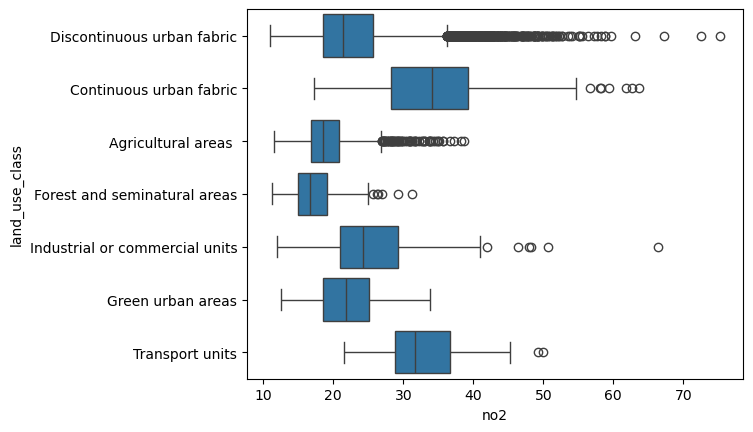

In [49]:
seaborn.boxplot(y="land_use_class", x="no2", data=subset)

Tweaking the figure a bit more (not asked in the exercise, but uncomment and run to see):

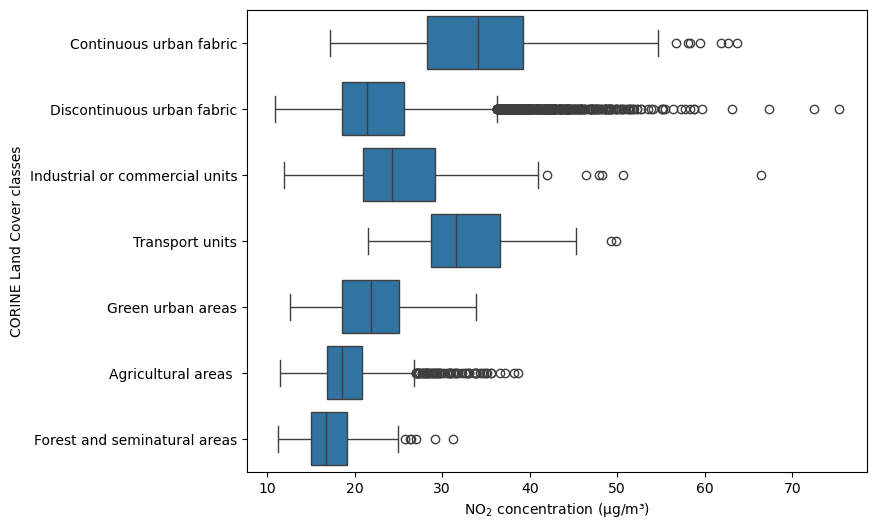

In [50]:
# defining custom order of the classes (following the order in the CORINE hierarchy as defined in the legend csv)
classes = legend["group"].unique()
# but removing the infrequent ones
counts = gdf['land_use_class'].value_counts()
frequent_categories = counts[counts > 50].index
classes = [value for value in classes if value in frequent_categories]

fig, ax = plt.subplots(figsize=(8, 6))
seaborn.boxplot(y="land_use_class", x="no2", data=subset, ax=ax, color="C0", order=classes)
ax.set(xlabel="NO$_2$ concentration (µg/m³)", ylabel="CORINE Land Cover classes");

The dense urban areas and areas close to large roads clearly have higher concentrations on average. On the countryside (indicated by "agricultural" areas) much lower concentrations are observed.

## A focus on Gent

Let's now focus on the measurements in Ghent. We first get the geometry of Gent from the municipalities dataframe, so we can use this to filter the measurements:

In [51]:
gent = muni[muni["NAAM"] == "Gent"].geometry.item()

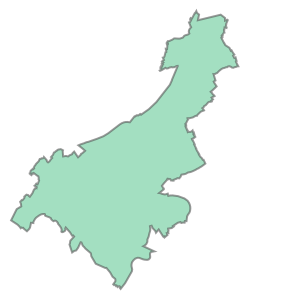

In [52]:
gent

<div class="alert alert-success">

**EXERCISE**:

For the exercise here, we don't want to select just the measurements in the municipality of Gent, but those in the region. For this, we will create a bounding box of Gent:
    
* Create a new Shapely geometry, `gent_region`, that defines the bounding box of the Gent municipality.

Check this section of the Shapely docs (https://shapely.readthedocs.io/en/latest/manual.html#constructive-methods) or experiment yourself to see which attribute is appropriate to use here (`convex_hull`, `envolope`, and `minimum_rotated_rectangle` all create a new polygon encompassing the original).

</div>

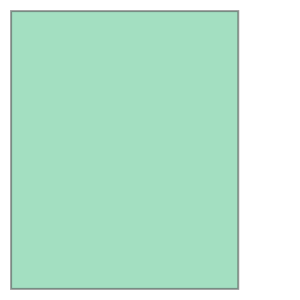

In [53]:
gent_region = gent.envelope
gent_region

<div class="alert alert-success">

**EXERCISE**:

* Using the `gent_region` shape, create a subset the measurements dataframe with those measurements located within Gent. Call the result `gdf_gent`.
* How many measurements are left in the subset?
    
<details><summary>Hints</summary>

* Ensure to use `gdf_lambert` and not `gdf`, since the `gent` shape is extracted from the `muni` dataframe with EPSG:31370 CRS.
* To check for a series of points whether they are located in a given polygon, use the `within()` method.
* Use the resulting boolean Series to mask the original `gdf` GeoDataFrame using boolean indexing (`[]` notation).
    
</details>

</div>

In [54]:
gdf_gent = gdf_lambert[gdf_lambert.within(gent_region)].copy()

In [55]:
len(gdf_gent)

1291

Alternatively, we can also use the `geopandas.clip()` function. For points there is not much difference with the method above, but for lines or polygons, it will actually "clip" the geometries, i.e. removing the parts that fall outside of the specified region (in addition, this method also uses a spatial index under the hood and will typically be faster for large datasets):

In [56]:
gdf_gent = geopandas.clip(gdf_lambert, gent_region).copy()
len(gdf_gent)

1291

<div class="alert alert-success">

**EXERCISE**:

* Make a visualization of the measurements in Gent. Use contextily to add a background basemap. Color the points based on the NO2 concentration.


<details><summary>Hints</summary>

* For using one of the columns of the GeoDataFrame to determine the fill color, use the `column=` keyword.
* To add a background map, use the `contextily.add_basemap()` function. It takes the matplotlib `ax` to which to add a map as the first argument.
* Remember that, to use a contextily background, the data needs to be in Web Mercator ("EPSG:3857").

</details>

</div>

In [57]:
import contextily

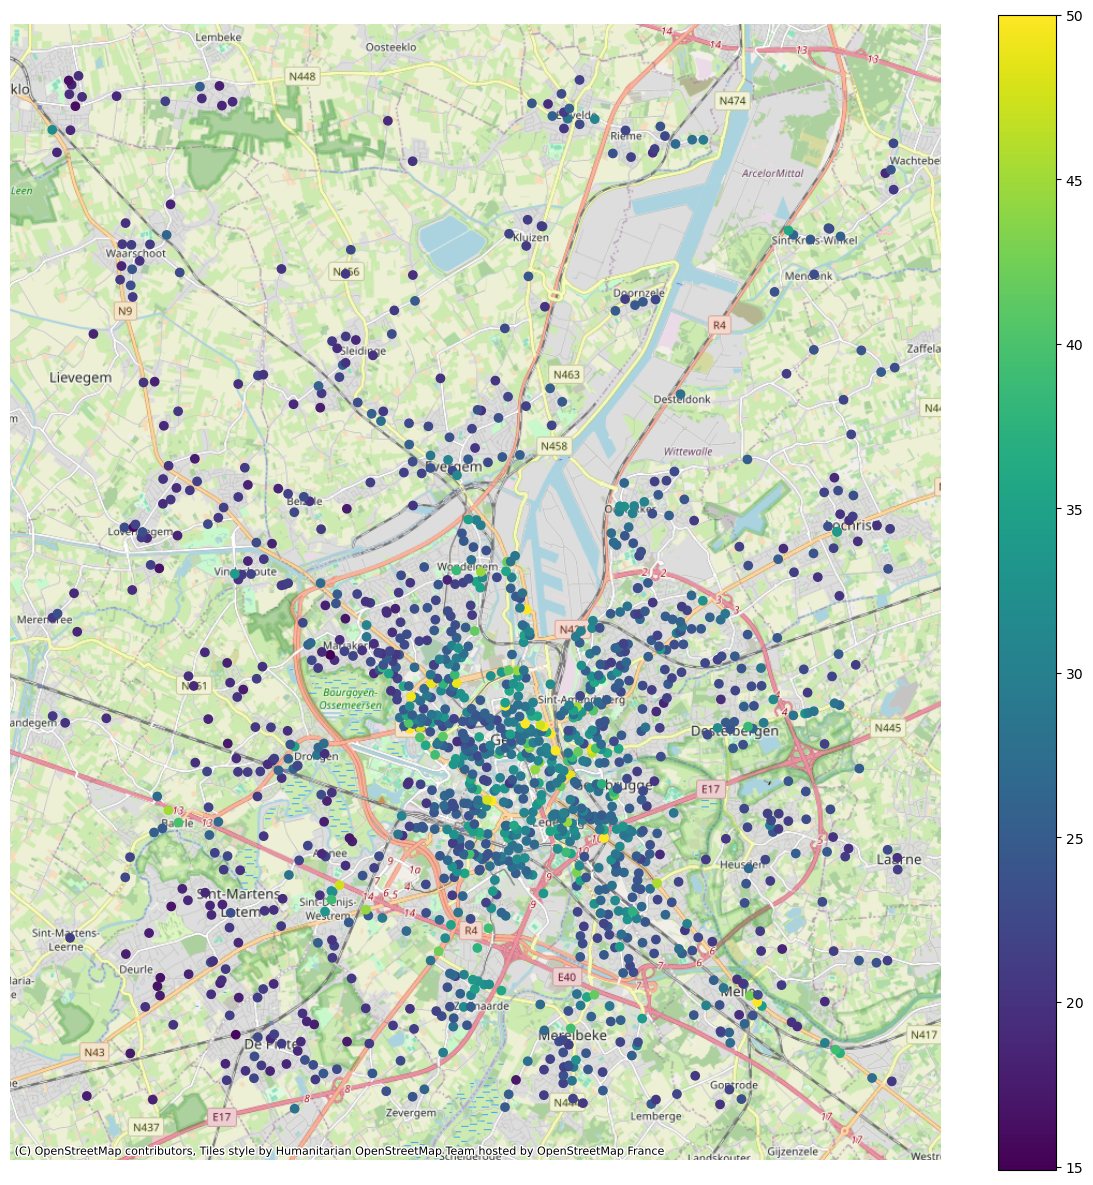

In [58]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = gdf_gent.to_crs(3857).plot(column="no2", ax=ax, legend=True, vmax=50)
contextily.add_basemap(ax)
ax.set_axis_off()

The solution above includes a `vmax=50` to indicate to use a max value of 50 for the colorbar range (there are few measurements with much higher values, that would otherwise make most other points look dark blue-ish). A better option can be to use one of the classification schemes from `mapclassify` through the `scheme` keyword.

Further zooming in on the city center, using a discrete color scheme and a different tile provider (not asked in exercise, but uncomment and run to see):

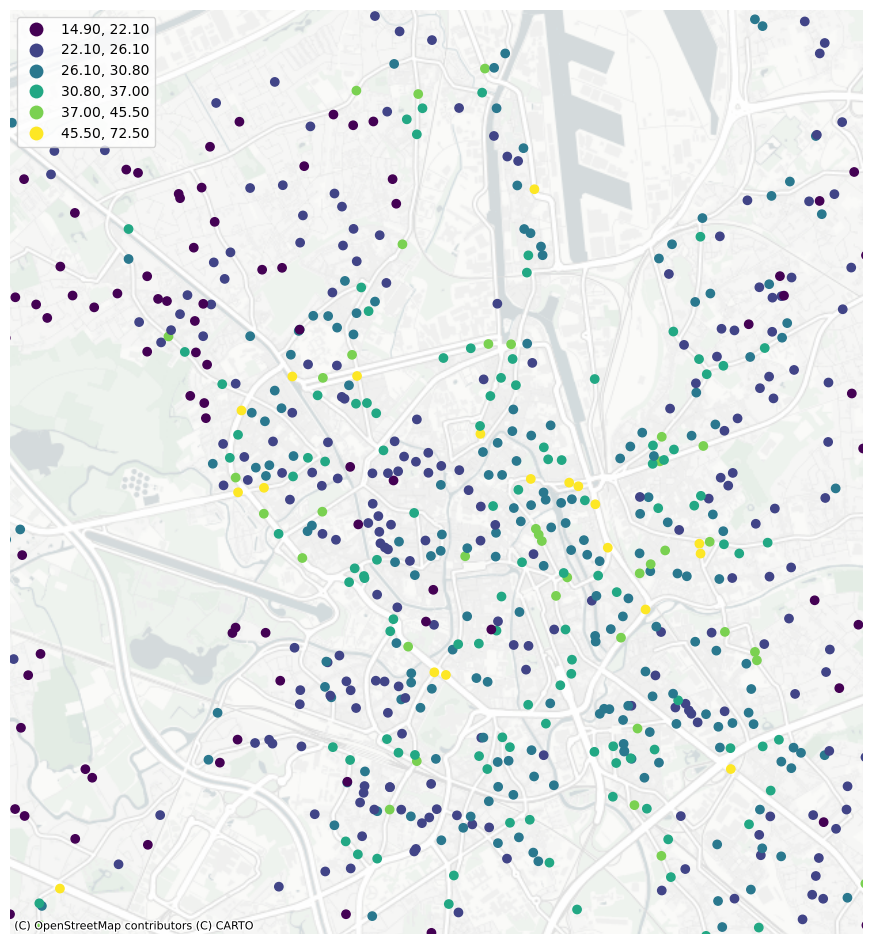

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = gdf_gent.to_crs(3857).plot(column="no2", ax=ax, scheme="NaturalBreaks", k=6, legend=True)
ax.set(xlim=(408_000, 420_000), ylim=(6_625_000, 6_638_000))
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()

## Combining with OpenStreetMap information

We downloaded and filtered OpenStreetMap data for the area of Gent, focusing on the street network information, and provided this as a GeoPackage file (`data/osm_network_gent.gpkg`, see this [notebook](./data/preprocess_data.ipynb#OpenStreetMap) to check the code to download and preprocess the raw OSM data).

The OpenStreetMap street network data includes information about the type of street in the "highway" tag. We can use this as a proxy for traffic intensity of the street, and relate that to the measured NO2 concentration.

<div class="alert alert-success">

**EXERCISE**:

* Read the `"data/osm_network_gent.gpkg"` file into a `streets` variable, and check the first rows.
* Convert the data to the appropriate CRS to combine with the `gdf_gent` data, if needed.
* Make a quick plot to explore the data.
    
</div>

In [65]:
streets = geopandas.read_file("data/osm_network_gent.gpkg")
streets.head()

highway                  name osm_type  \
0      primary   Oudenaardsesteenweg      way   
1      primary            Krijgslaan      way   
2  residential  Paul Fredericqstraat      way   
3  residential           Meersstraat      way   
4  residential  Jakob Heremansstraat      way   

                                            geometry  
0  LINESTRING (3.70951 51.01845, 3.70951 51.01863...  
1    LINESTRING (3.71157 51.02641, 3.71165 51.02642)  
2  LINESTRING (3.7134 51.04028, 3.71338 51.04032,...  
3    LINESTRING (3.71036 51.03886, 3.71041 51.03888)  
4  LINESTRING (3.71154 51.04173, 3.71149 51.04166...

In [66]:
streets = streets.to_crs("EPSG:31370")

<Axes: >

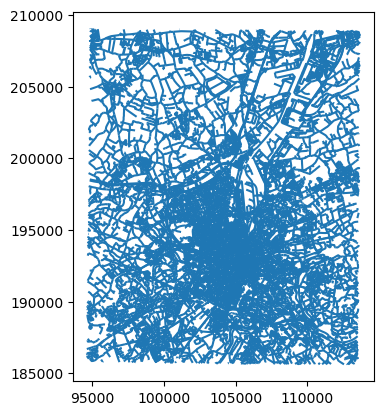

In [67]:
streets.plot()

<Axes: >

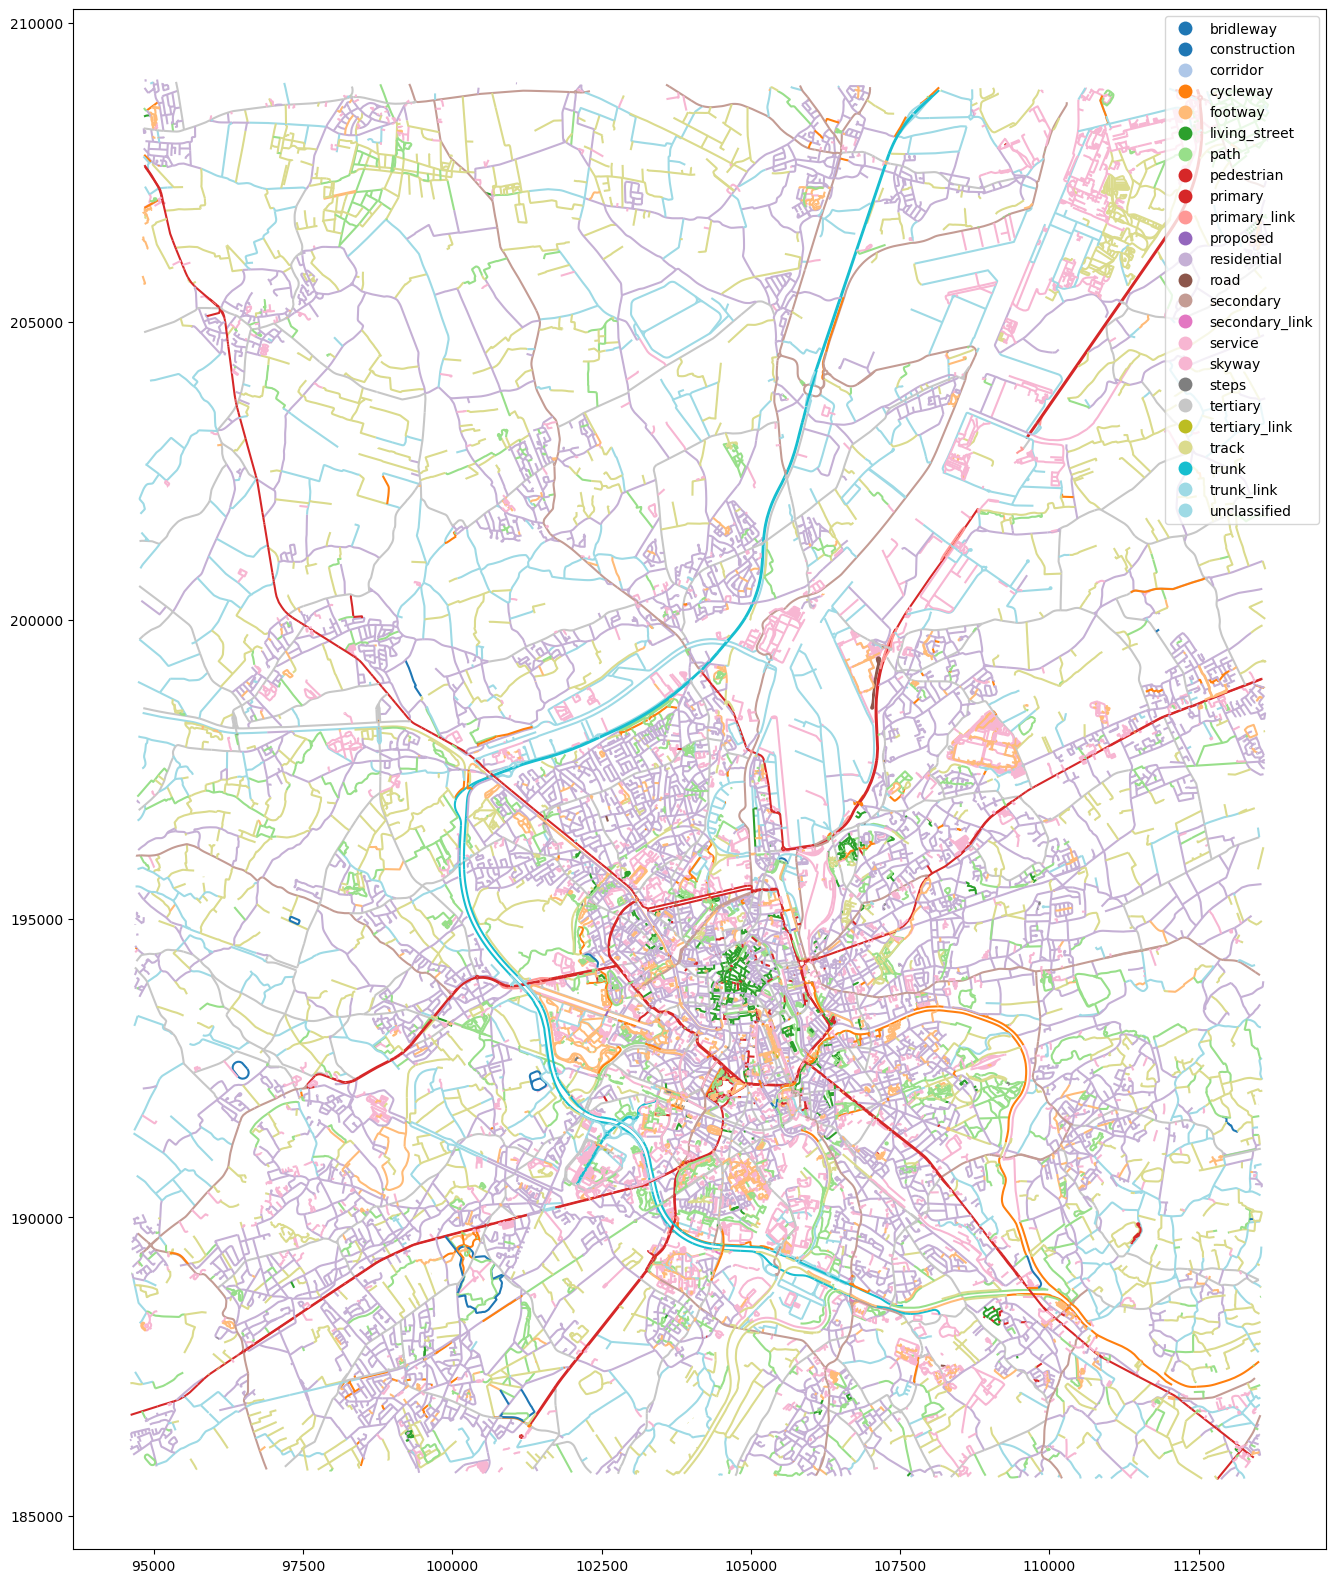

In [68]:
streets.plot(column="highway", figsize=(20, 20), legend=True, cmap="tab20")

(Note: for interactively exploring such data, there are better solutions as the GeoPandas `.plot()` method, such as opening the data in QGIS, or using an interactive visualization library, see notebook [visualization-04-interactive](./visualization-04-interactive.ipynb)).

To relate the measured concentration with the road type, we want to determine for each location at what type of street it is located. Since the measurements are not exactly located on one of the lines, we are going to look at the closest street for each location.

<div class="alert alert-success">

**EXERCISE**:

* Calculate the distance between the point (defined below) and all streets. And what is the minimum distance?
* Use the `idxmin()` method to know get the label of which row contains the minimum distance.
* Using the result of `idxmin()`, we can get the row or the value in the "highway" column that corresponds to the street that is closest to `point`.

<details><summary>Hints</summary>

* The distance method of a Shapely geometry does not accept a GeoSeries of geometries, only a single other geometry (so `point.distance(series)` does not work). However, the distance method is commutative, so you can always switch the order to use the distance method of the GeoSeries (`series.distance(point)` does work).
* Given a row label, you can get the value of a Series/column with `s[label]`, or the row of a DataFrame with `df.loc[label]`. With both row label and column name, you can get the corresponding value of a DataFrame with `df.loc[label, column_name]`.
</details>

</div>

We take the first point geometry in the Gent dataset:

In [69]:
point = gdf_gent["geometry"].iloc[0]

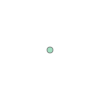

In [70]:
point

In [71]:
streets.distance(point)

0         8019.056168
1         8626.406101
2         9699.613880
3         9435.351505
4         9610.226364
             ...     
27198    11298.049498
27199    11257.251044
27200    15117.707937
27201    14709.116141
27202    14679.375762
Length: 27203, dtype: float64

In [72]:
streets.distance(point).min()

np.float64(1.2093373978670463)

In [73]:
idx_closest = streets.distance(point).idxmin()
idx_closest

4687

In [74]:
streets.loc[idx_closest]

highway                                             secondary
name                                               Klapstraat
osm_type                                                  way
geometry    LINESTRING (96892.31977463543 185779.607200785...
Name: 4687, dtype: object

In [75]:
streets["highway"][idx_closest]

'secondary'

In [76]:
streets.loc[idx_closest, "highway"]

'secondary'

We now want to repeat the above analysis for each measurement location. So let's start with writing a reusable function.

<div class="alert alert-success">

**EXERCISE**:

* Define a function `closest_road_type` that accepts a single point and the streets dataframe, and returns the class of the closest street.
* Check that the function works by using it on the `point` defined above.

As help, you can start from this skeleton:
    
```python
def closest_road_type(point, streets):
    # determine "highway" tag of the closest street
    idx_closest = ...
    ...
    return ... 
```

</div>

In [77]:
def closest_road_type(point, streets):
    """Type to the nearest road (OpenStreetMap)"""
    dist = streets.distance(point)
    idx_closest = dist.idxmin()
    return streets.loc[idx_closest, "highway"]

In [78]:
closest_road_type(point, streets)

'secondary'

Now we can apply this function to each of the point locations. However, with this brute force method, applying it as is using `gdf_gent` and `streets` takes quite some time. We can speed up the distance calculation by reducing the number of linestrings in the `streets` dataframe to compare with.

<div class="alert alert-success">

**EXERCISE**:

* Create a `streets_unioned` dataframe with a single line per road type (a union of all lines per road type). Check the `dissolve()` method for this.
* Repeat the `apply` call, but now on all points and using `streets_unioned` instead of `streets`.
* Assign the result of the apply to a new columns "road_type".
* Do a value counts of this new column.
    
</div>

When running this, you can see it already takes a bit of time, even for the first 20 rows:

In [79]:
%time gdf_gent.geometry.head(20).apply(lambda point: closest_road_type(point, streets))

CPU times: user 184 ms, sys: 246 μs, total: 184 ms
Wall time: 183 ms


969         secondary
5830     unclassified
2237      residential
12854     residential
664          tertiary
12027     residential
14292     residential
4569      residential
6623      residential
10245    unclassified
1239         tertiary
92           tertiary
12997         footway
795       residential
4883      residential
11369     residential
6414      residential
2835      residential
2586      residential
11283    unclassified
Name: geometry, dtype: object

In [80]:
streets_unioned = streets.dissolve("highway").reset_index()

In [81]:
gdf_gent["road_type"] = gdf_gent.geometry.apply(lambda point: closest_road_type(point, streets_unioned))

In [82]:
gdf_gent.head()

code campaign   no2        lat       lon  \
969    203442   facade  18.1  50.981310  3.611603   
5830   247920   facade  17.7  50.982050  3.590477   
2237   216270   facade  20.7  50.985232  3.635290   
12854  308130   facade  20.8  50.985380  3.663692   
664    200484   facade  24.3  50.986600  3.681987   

                            geometry     road_type  
969     POINT (96830.611 185944.564)     secondary  
5830    POINT (95347.996 186042.206)  unclassified  
2237    POINT (98498.203 186364.209)   residential  
12854   POINT (100492.635 186361.33)   residential  
664    POINT (101778.472 186485.015)      tertiary

In [83]:
gdf_gent["road_type"].value_counts()

road_type
residential      886
tertiary         208
secondary         61
primary           50
unclassified      39
living_street     22
service            7
track              5
path               4
cycleway           3
footway            3
pedestrian         3
Name: count, dtype: int64

**Note!** We have been using a brute-force search for the closest street by calculating for each point the distance to all streets. This is a good exercise to learn the syntax, but there are however better methods for such "nearest" queries. See eg https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

<div class="alert alert-success">

**EXERCISE**:

There are some uncommon categories. For the remainder of this demo, let's group some related categories, and filter out some others.
    
* Using the defined mapping, replace some values with "pedestrian" in the `"road_type"` column.
* Using the defined subset of categories, create a subset of `gdf_gent` where the road type "is in" this subset of categories (look at the pandas `isin()` ([doc link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html)) method). Call the result `subset`, and do again a value counts to check the result.
    
<details><summary>Hints</summary>

* The `replace()` method can be called on a column. Pass a dictionary to this method, and the keys of the dictionary present in the column will be replaces with the corresponding values defined in the dictionary.
* The `Series.isin()` method accepts a list of values, and will return a boolean Series indicating for each element of the original Series whether it is present in the list of values or not. 
* The boolean Series can then be used to filter the original `gdf_gent` dataframe using boolean indexing.
</details>

</div>

Replace categories:

In [84]:
mapping = {
    "footway": "pedestrian",
    "living_street": "pedestrian",
    "path": "pedestrian",
}

In [85]:
gdf_gent["road_type"] = gdf_gent["road_type"].replace(mapping)

Filter categories:

In [86]:
categories = ["primary", "secondary", "tertiary", "residential", "pedestrian"]

In [87]:
subset = gdf_gent[gdf_gent["road_type"].isin(categories)]

In [88]:
subset.groupby("road_type").size()  # subset["road_type"].value_counts()

road_type
pedestrian      32
primary         50
residential    886
secondary       61
tertiary       208
dtype: int64

<div class="alert alert-success">

**EXERCISE**:

* Calculate the average measured concentration depending on the type of the road next to the measurement location.

</div>

In [89]:
subset.groupby("road_type")['no2'].mean()

road_type
pedestrian     24.850000
primary        37.318000
residential    24.719413
secondary      30.209836
tertiary       28.471154
Name: no2, dtype: float64

<div class="alert alert-success">

**EXERCISE**:

* Similarly, make a plot with `seaborn` of those results. Specify the `categories` as the order to use for the plot.

</div>

In [90]:
import seaborn

<Axes: xlabel='road_type', ylabel='no2'>

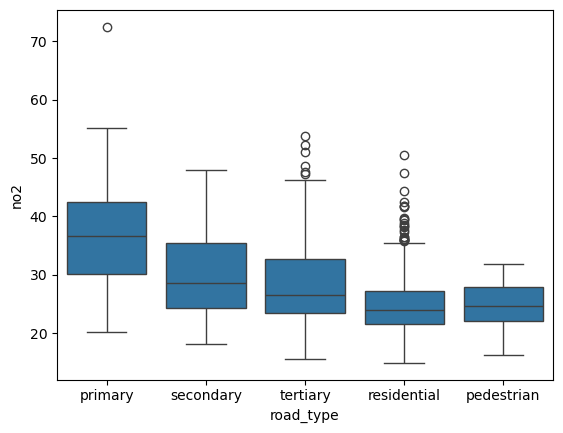

In [91]:
seaborn.boxplot(x="road_type", y="no2", data=subset, order=categories)

This analysis confirms that the NO2 concentration is clearly related to traffic.